In [1]:
import sigfig
import polars as pl
from refnx.analysis import Transform, GlobalObjective

import pyref.fitting as fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
energies = np.linspace(280, 290, 100)
cwd = Path.cwd()

ooc = pd.read_csv(cwd / "fitting/optical_constants.csv")
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def setp_from_tensor(slab, tensor):
    """Set parameters from tensor."""
    rbounds = (
        tensor.real.min() * 0.9,
        tensor.real.max() * 1.1,
    )
    ibounds = (
        1e-8,
        tensor.imag.max() * 1.1,
    )
    slab.sld.xx.setp(vary=True, bounds=rbounds)
    slab.sld.zz.setp(vary=True, bounds=rbounds)
    slab.sld.ixx.setp(vary=True, bounds=ibounds)
    slab.sld.izz.setp(vary=True, bounds=ibounds)
    return slab


def force_isotropic_beta(slab):
    """Force beta to be isotropic."""
    slab.sld.beta.setp(vary=True, bounds=slab.sld.ixx.bounds)
    slab.sld.ixx.setp(vary=None, constraint=slab.sld.beta)
    slab.sld.izz.setp(vary=None, constraint=slab.sld.beta)


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False, bounds=(2, 3))
    return slab


def sio2(energy, thick=8.7, rough=5.8, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=False, bounds=(1, 2.3))
    return slab


def contamination(energy, thick=11.5, rough=4.19, density=1.8, theta=MA):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(ooc, density=density, rotation=0, energy=energy, name=name)(
        thick, rough
    )
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(value=theta, vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=5.5, rough=4.4, density=1.46, theta=0.5):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(ooc, density=density, rotation=0, energy=energy, name=name)(
        thick, rough
    )
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(value=theta, vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=183.3, rough=8.8, density=1.654, theta=1.35):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=theta, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(energy, offset=0, rotations=[0, 1.21, MA]):
    """Construct the slab."""
    offset_energy = round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy, theta=rotations[0])
        | znpc(offset_energy, theta=rotations[1])
        | contamination(offset_energy, theta=rotations[2])
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy}"
    return slab

In [3]:
def q(theta, energy):
    """Calculate q from theta and energy."""
    theta_rad = np.radians(theta)
    # Use broadcasting to create a (len(theta), len(energy)) array
    return (
        4 * np.pi * np.sin(theta_rad[:, np.newaxis]) * energy[np.newaxis, :] / 12398.42
    )


In [ ]:
def fixed_angle(
    energies: np.ndarray,
    thetas: np.ndarray,
    pol: str,
    orientations: list,
):
    """Calculate reflectivity for a fixed angle scan."""
    q_values = q(thetas, energies)
    reflectivity = np.empty_like(q_values, dtype=float)

    # Loop over energies as model construction is energy-dependent
    for i, e in enumerate(energies):
        model_func = fit.ReflectModel(
            construct_slab(e, rotations=orientations),
            pol=pol,
            energy=e,
        )
        # Calculate for all thetas at once for a given energy
        reflectivity[:, i] = model_func(q_values[:, i])
    return reflectivity


# Define angles and interfaces
theta = np.array([25, 50])
interfaces = np.linspace(0, np.pi / 2, 100)

# Pre-allocate arrays to store s and p polarization data
s_data_all = np.zeros((len(theta), len(interfaces), len(energies)))
p_data_all = np.zeros((len(theta), len(interfaces), len(energies)))

# Loop over interface orientations
for j, itheta in enumerate(interfaces):
    orientation = [0.1, 0.1, itheta]
    s_data_all[:, j, :] = fixed_angle(
        energies, theta, pol="s", orientations=orientation
    )
    p_data_all[:, j, :] = fixed_angle(
        energies, theta, pol="p", orientations=orientation
    )

# Calculate the anisotropy ratio from the stored data
anisotropy_ratio = (s_data_all - p_data_all) / (s_data_all + p_data_all)

In [ ]:
def fixed_energy(
    energies: float,
    q_values: np.ndarray,
    pol: str,
    orientations: list,
):
    """Calculate reflectivity for a fixed angle scan."""
    model_func = fit.ReflectModel(
        construct_slab(energies, rotations=orientations),
        pol=pol,
        energy=energies,
    )
    reflectivity = model_func(q_values)
    return reflectivity


/tmp/ipykernel_2876/2192131189.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


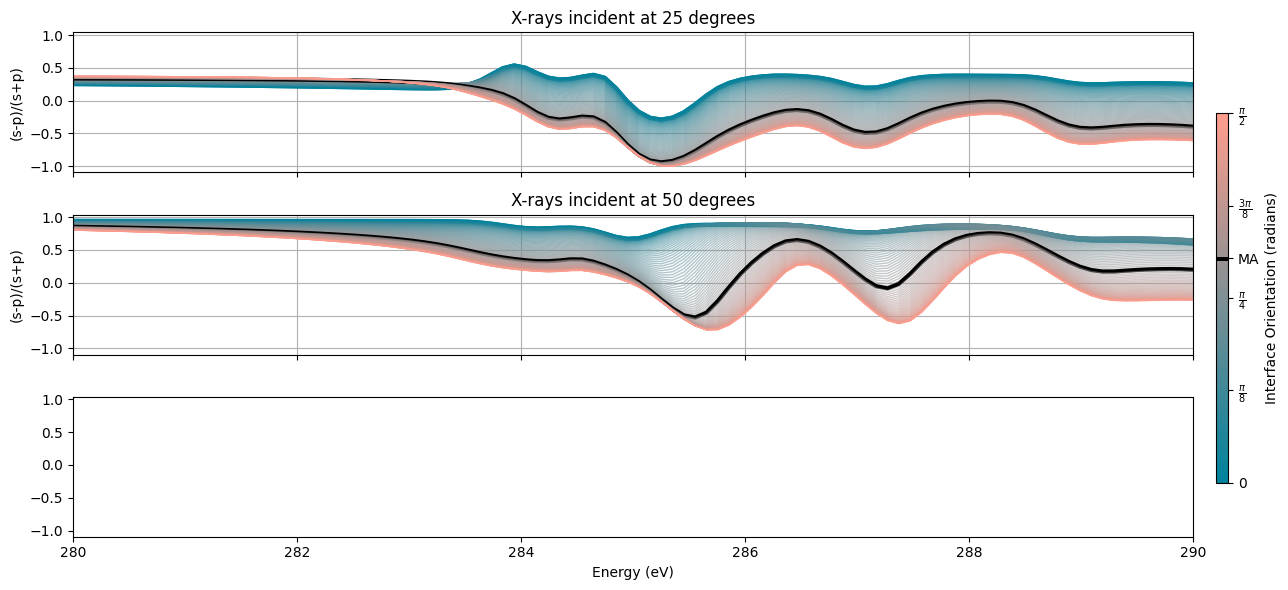

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Create base color palette
base_cmap = sns.color_palette("blend:#00829c,#ff9d8d", n_colors=len(interfaces))

# Find the interface closest to MA
ma_index = np.argmin(np.abs(interfaces - MA))

# Replace the color at MA index with black
cmap = base_cmap.copy()
cmap[ma_index] = (0, 0, 0)  # Black color for MA

fig, ax = plt.subplots(nrows=3, figsize=(12, 6), sharex=True, sharey=True)

for i, t in enumerate(theta):
    # Plot all interface orientations
    for j in range(len(interfaces)):
        if j == ma_index:
            # Plot MA interface in black
            ax[i].plot(
                energies,
                anisotropy_ratio[i, j, :],
                "k-",
                linewidth=3,
            )
        else:
            # Color code by interface orientation
            color = cmap[j]
            ax[i].plot(
                energies,
                anisotropy_ratio[i, j, :],
                color=color,
                alpha=0.5 if j not in [0, len(theta) - 1] else 1,
                linewidth=1 if j not in [0, len(theta) - 1] else 3,
            )

    ax[i].set_ylabel("(s-p)/(s+p)")
    ax[i].set_title(f"X-rays incident at {t} degrees")
    ax[i].set_xlim(energies.min(), energies.max())
    ax[i].grid()

# Add colorbar with black at MA position
ax[2].set_xlabel("Energy (eV)")
cmap_mpl = ListedColormap(cmap)
sm = plt.cm.ScalarMappable(
    cmap=cmap_mpl, norm=plt.Normalize(vmin=interfaces.min(), vmax=interfaces.max())
)
sm.set_array([])
cbar = fig.colorbar(
    sm, ax=ax, location="right", pad=0.02, shrink=0.8, aspect=30, anchor=(2.1, 0.5)
)
tick_labels = [
    "0",
    r"$\frac{\pi}{8}$",
    r"$\frac{\pi}{4}$",
    "MA",
    r"$\frac{3\pi}{8}$",
    r"$\frac{\pi}{2}$",
]
cbar.set_ticks([0, np.pi / 8, np.pi / 4, MA, 3 * np.pi / 8, np.pi / 2])
cbar.set_ticklabels(tick_labels)
cbar.set_label("Interface Orientation (radians)")

plt.tight_layout()
plt.show()


In [ ]:
s_data_all_2 = np.zeros((len(theta), len(interfaces), len(energies)))
p_data_all_2 = np.zeros((len(theta), len(interfaces), len(energies)))

# Loop over interface orientations
for j, itheta in enumerate(interfaces):
    orientation = [np.pi / 2, np.pi / 2, itheta]
    s_data_all_2[:, j, :] = fixed_angle(
        energies, theta, pol="s", orientations=orientation
    )
    p_data_all_2[:, j, :] = fixed_angle(
        energies, theta, pol="p", orientations=orientation
    )

anisotropy_ratio_2 = (s_data_all_2 - p_data_all_2) / (s_data_all_2 + p_data_all_2)

/tmp/ipykernel_2876/442763798.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


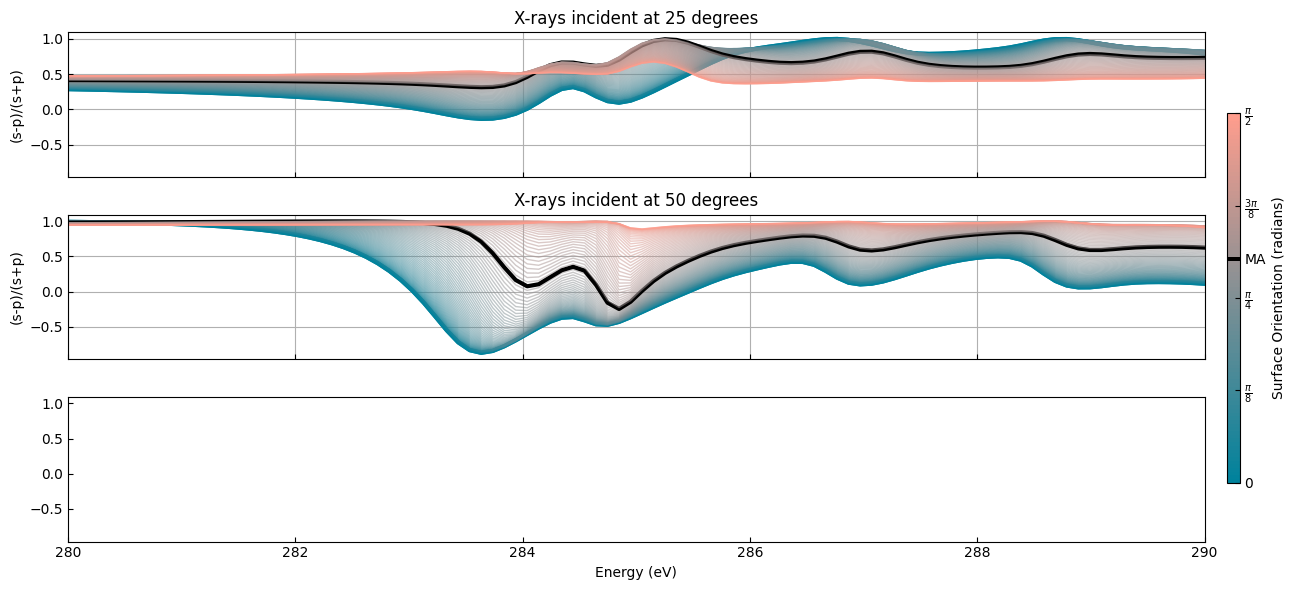

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Create base color palette
base_cmap = sns.color_palette("blend:#00829c,#ff9d8d", n_colors=len(interfaces))

# Find the interface closest to MA
ma_index = np.argmin(np.abs(interfaces - MA))

# Replace the color at MA index with black
cmap = base_cmap.copy()
cmap[ma_index] = (0, 0, 0)  # Black color for MA

fig, ax = plt.subplots(nrows=3, figsize=(12, 6), sharex=True, sharey=True)

for i, t in enumerate(theta):
    # Plot all interface orientations
    for j in range(len(interfaces)):
        if j == ma_index:
            # Plot MA interface in black
            ax[i].plot(
                energies,
                anisotropy_ratio_2[i, j, :],
                "k-",
                linewidth=3,
            )
        else:
            # Color code by interface orientation
            color = cmap[j]
            ax[i].plot(
                energies,
                anisotropy_ratio_2[i, j, :],
                color=color,
                alpha=0.5 if j not in [0, len(theta) - 1] else 1,
                linewidth=1 if j not in [0, len(theta) - 1] else 3,
            )

    ax[i].set_ylabel("(s-p)/(s+p)")
    ax[i].set_title(f"X-rays incident at {t} degrees")
    ax[i].set_xlim(energies.min(), energies.max())
    ax[i].grid()

# Add colorbar with black at MA position
ax[2].set_xlabel("Energy (eV)")
cmap_mpl = ListedColormap(cmap)
sm = plt.cm.ScalarMappable(
    cmap=cmap_mpl, norm=plt.Normalize(vmin=interfaces.min(), vmax=interfaces.max())
)
sm.set_array([])
cbar = fig.colorbar(
    sm, ax=ax, location="right", pad=0.02, shrink=0.8, aspect=30, anchor=(2.1, 0.5)
)
tick_labels = [
    "0",
    r"$\frac{\pi}{8}$",
    r"$\frac{\pi}{4}$",
    "MA",
    r"$\frac{3\pi}{8}$",
    r"$\frac{\pi}{2}$",
]
cbar.set_ticks([0, np.pi / 8, np.pi / 4, MA, 3 * np.pi / 8, np.pi / 2])
cbar.set_ticklabels(tick_labels)
cbar.set_label("Surface Orientation (radians)")

plt.tight_layout()
plt.show()


In [ ]:
#  set matplotlib ticks to point inward
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["text.usetex"] = True
# Add ticks to the top and right side of every axis
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
# Set the grids so that they are dashed
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
# Ensure grids draw on minor ticks
plt.rcParams["axes.grid.which"] = "both"

In [96]:
import seaborn as sns
from matplotlib.colors import ListedColormap

import matplotlib.colors as mcolors

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(7.5, 2 * 5 / 3),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    dpi=300,
)

# --- Plotting for the first experiment (left column) ---
# This is based on CELL INDEX 3, varying contamination layer orientation
base_cmap1 = sns.color_palette("blend:#00829c,#ff9d8d", n_colors=len(interfaces))
ma_index = np.argmin(np.abs(interfaces - MA))
cmap1 = base_cmap1.copy()
cmap1[ma_index] = (0, 0, 0)

for i, t in enumerate(theta):
    ax = axes[i, 0]
    for j in range(len(interfaces)):
        color = cmap1[j]
        linewidth = 3 if j == ma_index else 1
        alpha = 1 if j in [0, len(interfaces) - 1, ma_index] else 0.5
        ax.plot(
            energies,
            anisotropy_ratio[i, j, :],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
        )
    ax.set_ylabel("(s-p)/(s+p)")
    ax.set_title(f"Incident Angle: {t}°")
    ax.set_xlim(282, energies.max())
    ax.grid(True, linestyle="--", linewidth=0.5)

# --- Plotting for the second experiment (right column) ---
# This is based on CELL INDEX 5, varying surface layer orientation
# base_cmap2 = sns.color_palette("blend:#00579C,#FFC88D", n_colors=len(interfaces))
# cmap2 = base_cmap2.copy()
# cmap2[ma_index] = (0, 0, 0)

for i, t in enumerate(theta):
    ax = axes[i, 1]
    for j in reversed(range(len(interfaces))):
        color = cmap1[j]
        linewidth = 3 if j == ma_index else 1
        alpha = 1 if j in [0, len(interfaces) - 1, ma_index] else 0.5
        ax.plot(
            energies,
            anisotropy_ratio_2[i, j, :],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
        )
    ax.set_title(f"Incident Angle: {t}°")
    ax.grid(True, linestyle="--", linewidth=0.5)

# Set common x-labels
axes[1, 0].set_xlabel("Energy (eV)")
axes[1, 1].set_xlabel("Energy (eV)")

# --- Colorbars ---
tick_positions = [0, np.pi / 8, np.pi / 4, MA, 3 * np.pi / 8, np.pi / 2]
tick_labels = [
    "0",
    r"$\frac{\pi}{8}$",
    r"$\frac{\pi}{4}$",
    "MA",
    r"$\frac{3\pi}{8}$",
    r"$\frac{\pi}{2}$",
]

# Colorbar for the left plot
cmap_mpl1 = ListedColormap(cmap1)
sm1 = plt.cm.ScalarMappable(
    cmap=cmap_mpl1, norm=plt.Normalize(vmin=interfaces.min(), vmax=interfaces.max())
)
cbar1 = fig.colorbar(
    sm1, ax=axes[:, 1], location="right", pad=0.02, shrink=0.8, aspect=30
)
cbar1.set_ticks(tick_positions)
cbar1.set_ticklabels(tick_labels)
cbar1.set_label("Interface Orientation (radians)")

# Colorbar for the right plot
# cmap_mpl2 = ListedColormap(cmap2)
# sm2 = plt.cm.ScalarMappable(
#     cmap=cmap_mpl2, norm=plt.Normalize(vmin=interfaces.min(), vmax=interfaces.max())
# )
# cbar2 = fig.colorbar(
#     sm2, ax=axes[:, 1], location="right", pad=0.02, shrink=0.8, aspect=30
# )
# cbar2.set_ticks(tick_positions)
# cbar2.set_ticklabels(tick_labels)
# cbar2.set_label("Surface Orientation (radians)")

plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2250x1000 with 5 Axes>

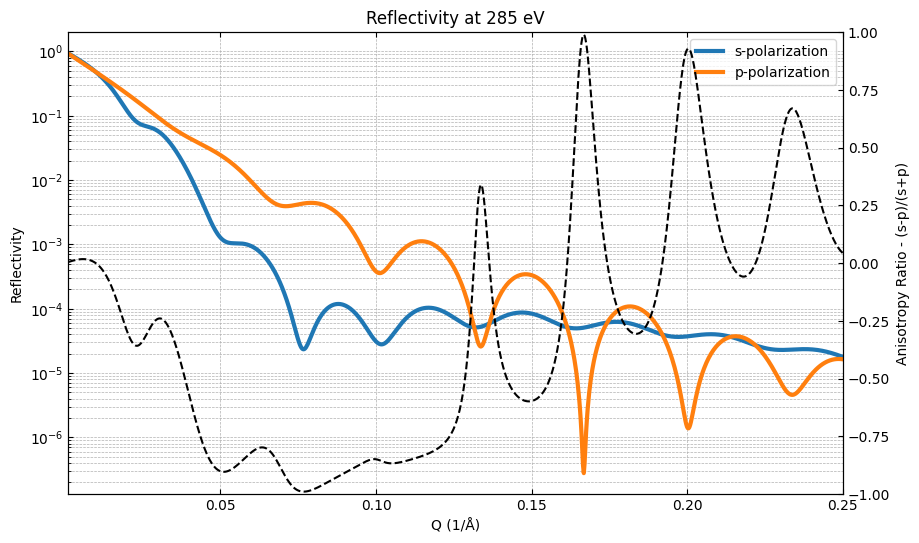

In [74]:
target_energy = 285
q_range = np.linspace(0.001, 0.25, 1000)

s_data = fixed_energy(target_energy, q_range, "s", [0.1, 0.1, np.pi / 2])
p_data = fixed_energy(target_energy, q_range, "p", [0.1, 0.1, np.pi / 2])

#  plot on log log scale
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(q_range, s_data, label="s-polarization", lw=3)
ax.plot(q_range, p_data, label="p-polarization", lw=3)
ax.set_xlabel("Q (1/Å)")
ax.set_ylabel("Reflectivity")
ax.set_title(f"Reflectivity at {target_energy} eV")
ax.set_yscale("log")
ax.legend()
ax.grid(True, which="both")

ani_x = ax.twinx()
ani_x.plot(
    q_range,
    (s_data - p_data) / (s_data + p_data),
    label="Anisotropy Ratio",
    color="k",
    linestyle="--",
    zorder=0,
)
ani_x.set_ylabel("Anisotropy Ratio - (s-p)/(s+p)")
ani_x.set_ylim(-1, 1)
ax.set_xlim(q_range.min(), q_range.max())
fig.align_labels()
plt.show()


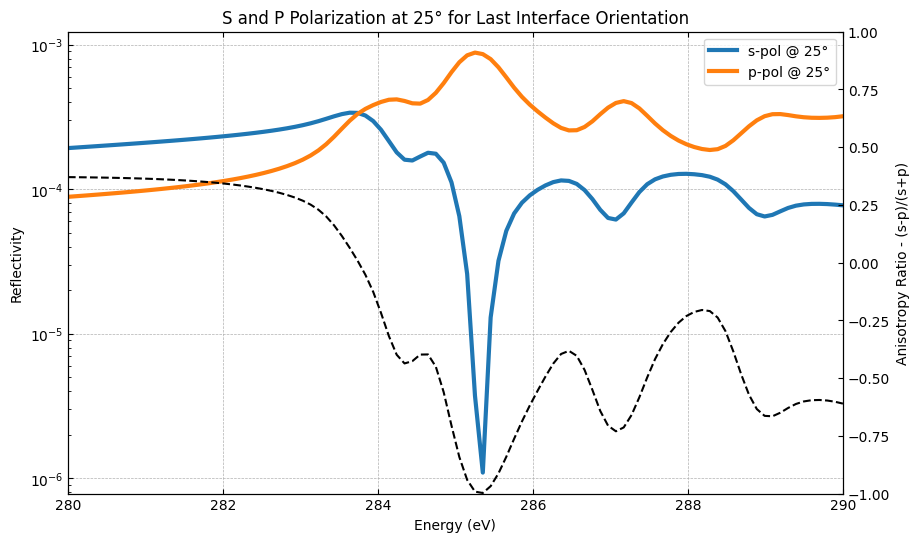

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

# The index for the 25-degree angle in the theta array [10, 25, 50] is 1.
angle_index = 0

# The index for the last interface orientation is -1.
interface_index = -1

# Plot s and p polarization data for the specified configuration
ax.plot(
    energies,
    s_data_all[angle_index, interface_index, :],
    label=f"s-pol @ {theta[angle_index]}°",
    lw=3,
)
ax.plot(
    energies,
    p_data_all[angle_index, interface_index, :],
    label=f"p-pol @ {theta[angle_index]}°",
    lw=3,
)

ani_x = ax.twinx()
ani_x.plot(
    energies,
    anisotropy_ratio[angle_index, interface_index, :],
    label=f"a-pol @ {theta[angle_index]}°",
    color="k",
    linestyle="--",
    zorder=0,
)
ani_x.set_ylabel("Anisotropy Ratio - (s-p)/(s+p)")
ani_x.set_ylim(-1, 1)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Reflectivity")
ax.set_title(
    f"S and P Polarization at {theta[angle_index]}° for Last Interface Orientation"
)
ax.legend()
ax.grid(True)
ax.set_yscale("log")
ax.set_xlim(energies.min(), energies.max())
fig.align_labels()
plt.show()

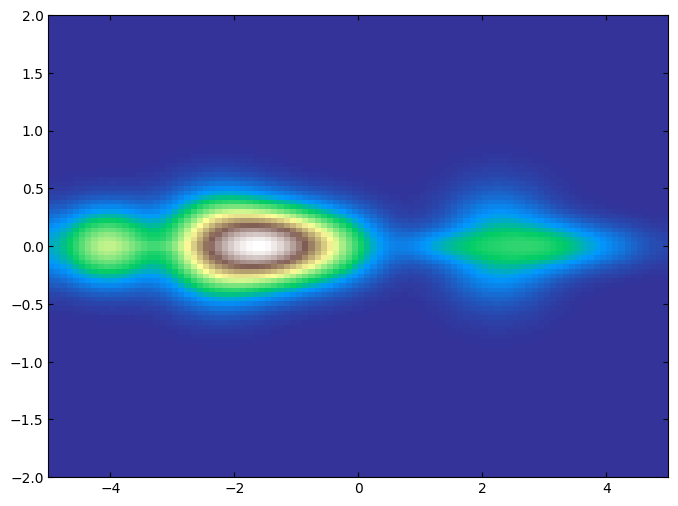

In [76]:
from scipy.ndimage import gaussian_filter


def gaus_beam_2d(x, y, w0, z):
    """
    Generate a 2D Gaussian beam profile.

    Parameters:
    - x: x-coordinates (numpy array)
    - y: y-coordinates (numpy array)
    - w0: beam waist (radius) at the focus
    - z: axial position (distance along the beam propagation direction)

    Returns:
    - intensity: 2D Gaussian beam intensity profile (numpy array)
    """
    # Calculate the Rayleigh range
    zR = np.pi * w0**2 / 532e-9  # wavelength is 532 nm

    # Calculate the beam radius at position z
    w = w0 * np.sqrt(1 + (z / zR) ** 2)

    # Create a 2D grid of coordinates
    X, Y = np.meshgrid(x, y)

    # Calculate the intensity profile
    intensity = (2 * (w0 / w) ** 2) * np.exp(-2 * (X**2 + Y**2) / w**2)

    return intensity


#  add in a horizontal smear
def gaus_beam_2d_smear(x, y, w0, z, smear_amount):
    """
    Generate a 2D Gaussian beam profile with horizontal smear.

    Parameters:
    - x: x-coordinates (numpy array)
    - y: y-coordinates (numpy array)
    - w0: beam waist (radius) at the focus
    - z: axial position (distance along the beam propagation direction)
    - smear_amount: amount of horizontal smear to apply

    Returns:
    - intensity: 2D Gaussian beam intensity profile with smear (numpy array)
    """
    intensity = gaus_beam_2d(x, y, w0, z)

    # Apply horizontal smear
    intensity = gaussian_filter(intensity, sigma=(0, smear_amount))

    return intensity


#  Plot the horizontally smeared beam profile on a ccd as a 2d image
def gaussian_beam_2d(x, y, ints, w0: list, z, smear_amount, n_beams=3):
    centers = np.linspace(x.min(), x.max(), n_beams + 2)
    #  grab just the central n_beams points from the cdenters to remove the far left
    # far right centers
    centers = centers[1:-1]
    intensity = np.zeros((len(y), len(x)))
    #  sample the ints at the locations of the centers
    sampled_ints = np.interp(centers, np.linspace(x.min(), x.max(), len(ints)), ints)

    for w, center, i in zip(w0, centers, sampled_ints):
        intensity += i * gaus_beam_2d_smear(x - center, y, w, z, smear_amount)
    return intensity


seed = 2

np.random.seed(seed)

x = np.linspace(-5, 5, 100)
y = np.linspace(-2, 2, 100)
n_beams = 10
intensity = gaussian_beam_2d(
    x=x,
    y=y,
    ints=s_data_all[angle_index, interface_index, :],
    w0=np.random.rand(n_beams),
    z=0,
    smear_amount=5,
    n_beams=n_beams,
)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    intensity,
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin="lower",
    aspect="auto",
    cmap="terrain",
)
ax.tick_params(axis="both", which="both", labelsize=10, top=True, right=True)
plt.show()

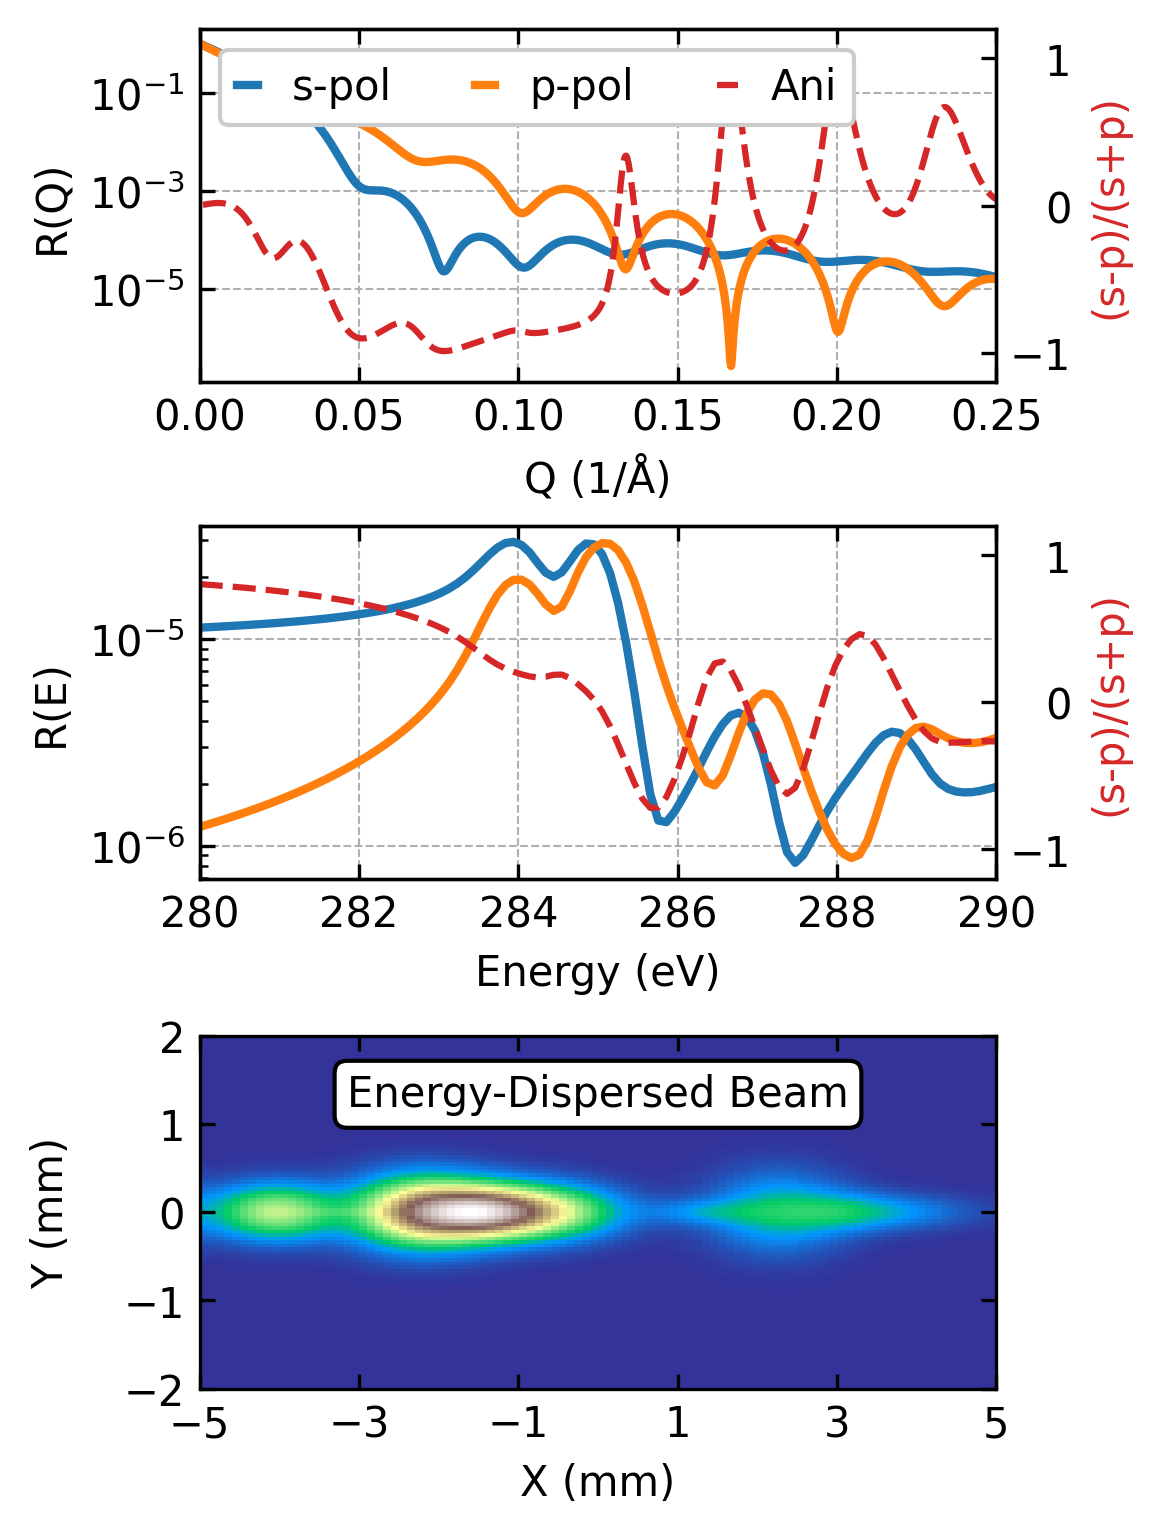

In [92]:
# Define global colors
S_COLOR = "C0"
P_COLOR = "C1"
ANI_COLOR = "C3"

# Create a figure with 3 rows for the stacked plots
fig, axes = plt.subplots(
    nrows=3, figsize=(7.5 / 2, 5), constrained_layout=True, dpi=300
)

# --- Plot 1: Reflectivity vs Q (from CELL INDEX 9) ---
ax1 = axes[0]
ax1.plot(q_range, s_data, label="s-pol", lw=2, color=S_COLOR)
ax1.plot(q_range, p_data, label="p-pol", lw=2, color=P_COLOR)
ax1.set_xlabel("Q (1/Å)")
ax1.set_ylabel("R(Q)")
ax1.set_yscale("log")
ax1.grid(True, which="both")
ax1.set_xlim(0, q_range.max())

ani_x1 = ax1.twinx()
ani_x1.plot(
    q_range,
    (s_data - p_data) / (s_data + p_data),
    label="Ani",
    color=ANI_COLOR,
    linestyle="--",
    zorder=-10,
)
ani_x1.set_ylabel("(s-p)/(s+p)", color=ANI_COLOR)
ani_x1.set_ylim(-1.2, 1.2)
# Combine legends from both y-axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ani_x1.get_legend_handles_labels()
legend = ani_x1.legend(
    h1 + h2,
    l1 + l2,
    ncols=3,
    loc="upper left",
    handlelength=0.5,
    facecolor="white",
    framealpha=1,
)

# --- Plot 2: Fixed Angle Traces (from CELL INDEX 10) ---
ax2 = axes[1]
angle_index = 1  # 25 degrees
interface_index = -1  # Last interface

ax2.plot(
    energies,
    s_data_all[angle_index, interface_index, :],
    lw=2,
    color=S_COLOR,
)
ax2.plot(
    energies,
    p_data_all[angle_index, interface_index, :],
    lw=2,
    color=P_COLOR,
)
ax2.set_ylabel("R(E)")
ax2.set_xlabel("Energy (eV)")
ax2.grid(True)  # , which="both")
ax2.set_yscale("log")
ax2.set_xlim(energies.min(), energies.max())

ani_x2 = ax2.twinx()
ani_x2.plot(
    energies,
    anisotropy_ratio[angle_index, interface_index, :],
    color=ANI_COLOR,
    linestyle="--",
    zorder=0,
)
ani_x2.set_ylabel("(s-p)/(s+p)", color=ANI_COLOR)  # , alpha=0.5)
ani_x2.set_ylim(-1.2, 1.2)

ani_x1.set_yticks([-1, 0, 1])
for label in ani_x1.get_yticklabels():
    label.set_ha("right")
ani_x1.tick_params(axis="y", pad=18)

# Right-align the tick labels on the twinned y-axis and add padding
ani_x2.set_yticks([-1, 0, 1])
for label in ani_x2.get_yticklabels():
    label.set_ha("right")
ani_x2.tick_params(axis="y", pad=18)


# --- Plot 3: 2D Smeared Beam Profile (from CELL INDEX 11) ---
ax3 = axes[2]
im = ax3.imshow(
    intensity,
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin="lower",
    aspect="auto",
    cmap="terrain",
)
ax3.set_ylabel("Y (mm)")
ax3.set_xlabel("X (mm)")
ax3.tick_params(axis="both", which="both", labelsize=10, top=True, right=True)

# Align ax3 x-ticks with ax2 x-ticks without removing ax2 labels
# Force drawing to ensure tick locations are calculated for ax2
fig.canvas.draw()

# Get tick locations from ax2 and map them to the range of ax3
ax2_ticks = ax2.get_xticks()
ax2_lim = ax2.get_xlim()
ax3_lim = ax3.get_xlim()

# Normalize and scale ticks
norm_ticks = (ax2_ticks - ax2_lim[0]) / (ax2_lim[1] - ax2_lim[0])
ax3_ticks = norm_ticks * (ax3_lim[1] - ax3_lim[0]) + ax3_lim[0]

ax3.set_xticks(ax3_ticks)
# You can set custom labels for ax3 here if needed, e.g.:
# ax3.set_xticklabels([f'{tick:.1f}' for tick in ax3_ticks])
#  add a legend type thing to ax3 that labels what it is
ax3.annotate(
    "Energy-Dispersed Beam",
    xy=(0.5, 0.8),
    xycoords="axes fraction",
    ha="center",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

fig.align_labels()
plt.show()

In [11]:
import pickle

with open(cwd / "fitting/fitting_results.pkl", "rb") as f:
    fit_obj = pickle.load(f)

In [12]:
print(fit_obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1.05948 +/- 0.0127, bounds=[0.6, 1.4]>
<Parameter:   'scale_p'   , value=1.19571 +/- 0.0142, bounds=[0.6, 1.4]>
<Parameter:'energy_offset', value=-0.00173561 +/- 0.00207, bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_s', value=0.662073 +/- 0.0145, bounds=[-0.8, 0.8]>
<Parameter:'theta_offset_p', value=0.388209 +/- 0.0149, bounds=[-0.8, 0.8]>
<Parameter:'Surface_283.7_thick', value=5.53154 +/- 0.323, bounds=[0.0, 12.0]>
<Parameter:'Surface_283.7_rough', value=4.41162 +/- 0.146, bounds=[0.0, 5.0]>
<Parameter:'Surface_283.7_density', value=1.46552 +/- 0.0326, bounds=[1.0, 1.8]>
<Parameter:'Surface_283.7_rotation', value=45.9278 +/- 0.457, bounds=[0.0, 1.5707963267948966]>
<Parameter:'ZnPc_283.7_thick', value=183.323 +/- 0.395, bounds=[180.0, 210.0]>
<Parameter:'ZnPc_283.7_rough', value=12.8186 +/- 0.24 , bounds=[2.0, 16.0]>
<Parameter:'ZnPc_283.7_de